In [1]:
import sys
import os

# Add the path to the directory where your module is located
module_path = os.path.abspath(os.path.join('..', 'C:\\Users\\pier1\\OneDrive\\Desktop\\uni\\Master\\2.Semester\\Machine Learning (WIWI)\\Project\\Data for depression\\'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import your module
from helpers import *

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from NN import *

Use the models to predict the test data and use the confusion matrix and their metrices (accuracy, precision, recall and f1-score)

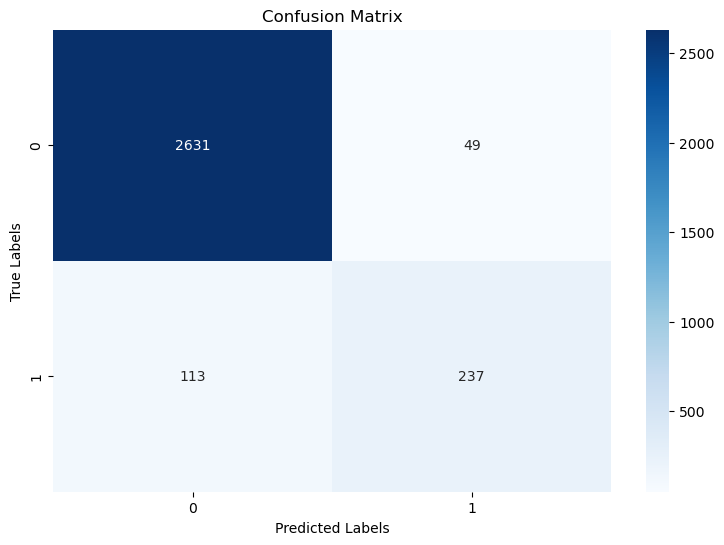

Accuracy:  0.9465346534653465
Precision:  0.8286713286713286
Recall:  0.6771428571428572
F1:  0.7452830188679245


In [3]:
input_size = 56
hidden_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_phq_9 = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_phq_9.load_state_dict(torch.load('BP_PHQ_9.pth'))
model_phq_9.eval()
true_labels_all, predicted_labels_all, TN, FP, FN, TP = evaluate(model_phq_9, device, 'BP_PHQ_9')


accuracy, precision, recall, f1 = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)


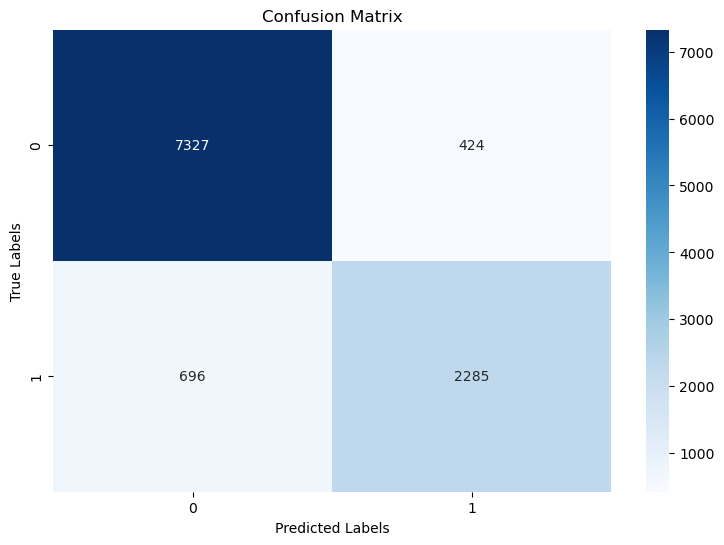

Accuracy:  0.8956392098397317
Precision:  0.843484680693983
Recall:  0.7665213015766521
F1:  0.8031634446397187


In [4]:
model_mh_phq_s = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_mh_phq_s.load_state_dict(torch.load('MH_PHQ_S.pth'))
model_mh_phq_s.eval()
true_labels_all, predicted_labels_all, TN, FP, FN, TP = evaluate(model_mh_phq_s, device, 'MH_PHQ_S')


accuracy, precision, recall, f1 = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

- The recall is really important here, because we want to detect as many people with depression as possible (TP+FN)
- The F1 Score is important aswell, because of the imbalanced dataset